# Context

We observe $n$ clients. Each client $i$ survives for a duration of $T_i\geq 1$ month. Let a random sample of $n$ iid random variables $T_1 , \ldots , T_n$ following an exponential distribution of unknown parameter $\theta$. From $T$ is defined $Y$ such that:
$$Y_i = \min (T_i, a_i)$$
Where:
* $\mathcal{A} := \{i \in \{1,2,...,n\} : Y_i< a_i\}$
* $a_i$ is the duration from the arrival of client $i$ to time of observation
* $Y_i$ is the duration before the client $i$ churned

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pareto
import random
import functions as f

```import functions as f``` : imports the package where we defined all of our functions

In [2]:
#GLOBAL CONSTANTS
clv_theory = 10 
size= 10000 # size of each sample
n = 10000 # number of samples
DureeObs = 12*2 # duration of observation

## Exponential (not censored)

In this case, we suppose that the data has an exponential distribution. We assume that there are no censored data : all the durations are known. 

[Text(0.5, 1.0, 'Exponential distribution')]

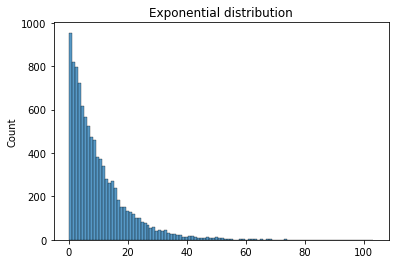

In [3]:
sns.histplot( f.generate_nc_exponential(clv_theory, size)).set(title="Exponential distribution")

**CLV computing**

First, we are going to use a Monte Carlo simulation where we generate `n` samples and compute the clv values with the theoretical estimator. After that, we are going to see how it converges to the supposed clv in theory.


The theoretical estimator is given by:

$$\hat{CLV} := \frac{\sum_{i=1}^n y_i}{n}$$

In [4]:
# CONSTANT : 0 if data is not censored, 1 else
censored = 0
# Monte Carlo simulation
clv_exp_nc, Y_n = f.monte_carlo(clv_theory, size, n, censored, f.exp_nc_clv_estimator, f.generate_nc_exponential)

CONVERGENCE :
 	 size of each dataset =10000 
 	 number of datasets =10000 
 	 CLV thoery = 10.00 
 	 CLV real = 9.999001  
 	 Standard deviation CLV= 0.100798


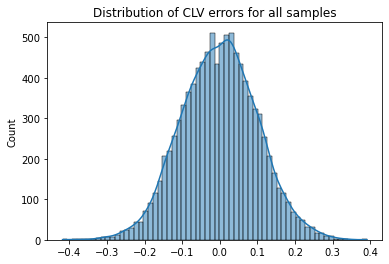

In [5]:
f.print_conv_plot_distribution(size, n ,clv_theory, clv_exp_nc)

The plot illustrates that the prediction errors follow a Gaussian distribution with a mean of zero. This indicates that, as per the Law of Large Numbers, the estimator tends to converge towards the theoretical value which can be visualised in the following plot.

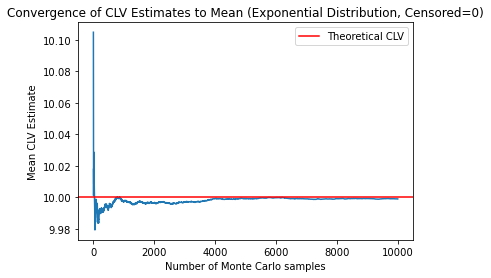

In [6]:
f.clv_convergence(clv_exp_nc, clv_theory,n , 'Convergence of CLV Estimates to Mean (Exponential Distribution, Censored=0)')

**Confidence interval - Monte Carlo**

Since, we don't have the thoeretical approach to compute confidence interval for our best CLV estimator, we use the Monte Carlo method which is supposed to converge to the theoretical values.

(cf. Exponential(censored) case for the proof)

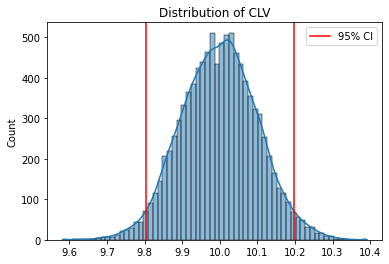

IC = [9.804898 , 10.198623 ] 


In [7]:
lower_exp_nc, upper_exp_nc = f.CI_plot_95(clv_exp_nc, 0.05)

95% of the CLV values of the all the Monte Carlo samples are within this confidence interval.

## Exponential (censored)

In this second case, we suppose that the data has an exponential distribution. But here, We assume that there are censored data.

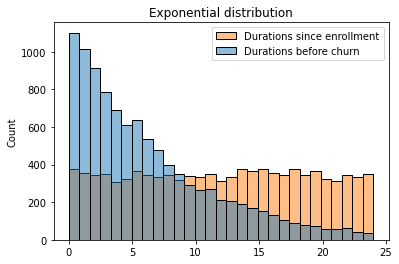

In [8]:
sns.histplot( f.generate_exponential(clv_theory, size,DureeObs)).set(title="Exponential distribution")
plt.legend(['Durations since enrollment','Durations before churn'])
plt.show()

For a giver customer, if its `Duration before churn <Duration since enrollment` it means that he churned, else he's still in the company.

**CLV computing**

Let's study the coherence of the estimator (based on exponential distribution with censored data).

The theoretical estimator is given by: 
$$\hat{CLV} := \frac{\sum_{i=1}^n y_i}{|\mathcal{A}|}$$

In [9]:
# CONSTANT
censored = 1
# Monte Carlo simulation
clv_exp_c, Y_n =f. monte_carlo(clv_theory, size, n, censored, f.exp_c_clv_estimator, f.generate_exponential)

CONVERGENCE :
 	 size of each dataset =10000 
 	 number of datasets =10000 
 	 CLV thoery = 10.00 
 	 CLV real = 10.001657  
 	 Standard deviation CLV= 0.125780


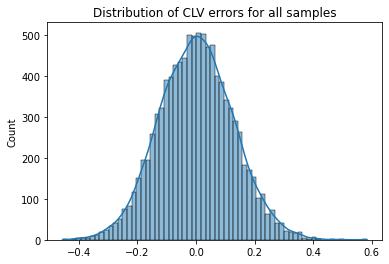

In [10]:
f.print_conv_plot_distribution(size, n ,clv_theory, clv_exp_c)

The error is still normally distributed so we have the same type of convergence as the previous case. However, censored data increases the std by 40% comparing to non censored data.

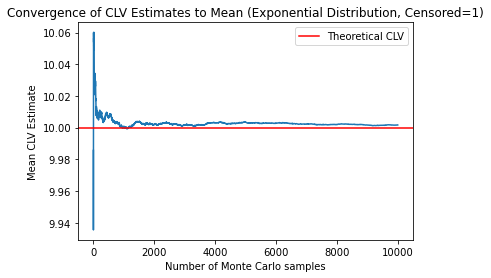

In [11]:
f.clv_convergence(clv_exp_c, clv_theory,n , 'Convergence of CLV Estimates to Mean (Exponential Distribution, Censored=1)')

**Theoretical confidence intervals**

For exponential distribution with censored data we found the theoretical formula. For $ q_{1-\frac{\alpha}{2}} = 1.95 $:
$$ IC_{95\%} = \left[ \frac{\sum_{i=1}^n Y_i}{|\mathcal{A}|  +  1.96\sqrt{|\mathcal{A}| }} , \frac{\sum_{i=1}^n Y_i}{|\mathcal{A}|  -  1.96\sqrt{|\mathcal{A} |}} \right]$$

(cf report for further details)

In [12]:
lower_exp_c = [] 
upper_exp_c = []
# for every dataset we compute the lower an upper bound
for i in range(n):
    lower_exp_c.append(f.CI_exp_c_clv(1.96, Y_n[i][0], Y_n[i][1])[0])
    upper_exp_c.append(f.CI_exp_c_clv(1.96, Y_n[i][0], Y_n[i][1])[1])

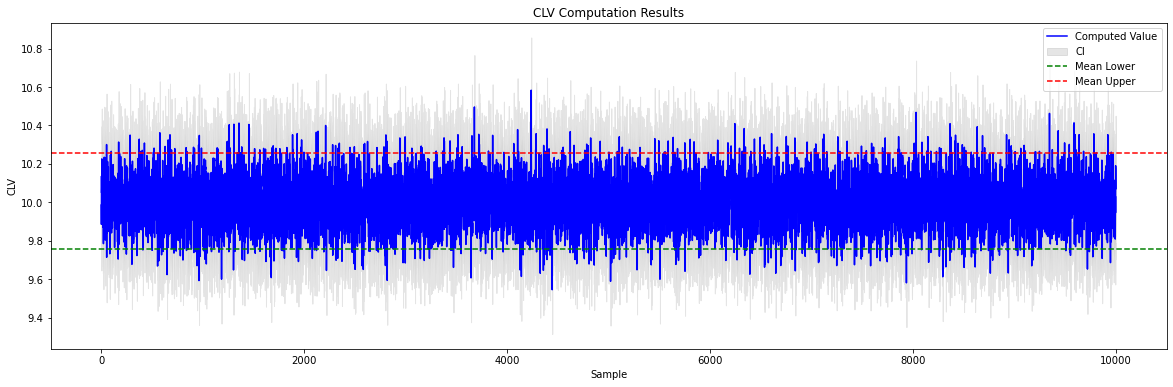

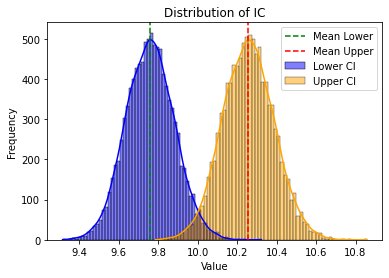

Theoretical CI = [9.75893019586464, 10.256766658615433].
CONFIDENCE LEVEL: 95.17% of estimators are within this interval


In [13]:
# plot confidence interval
f.CI_multiplot(clv_exp_c, lower_exp_c, upper_exp_c)

Using the Monte Carlo method is an efficient approach to test the theoretical formula, as it yields similar results to those obtained in theory thanks to Law of Large Numers. So, to check the confidence level of theoretical CI, we compute the CLV values of the n samples (generated with Monte Carlo simulation) and then check if 95% are within it. As we can see after the plots, approximately 95% of clv valus are indeed inside the theoretical confidence interval. Hence, the validation of the confidence interval calculted in theory.

**Bootstrap confidence intervals**

Although the confidence intervals have been calculated using the theoretical formula, the purpose of this section is to verify the results using the bootstrap method. In reality, it is hard to know the exact distribution of the data. So we can't really have a theoretical formula. Also, we can't generate n datasets with Monte Carlo to approach the theory, we only have one dataset. So the best way to cover all these issues is to create bootstrap samples and compute the 95% confidence interval using the resulted gaussian distribution.

To prove that this method works, we generate one dataset and we use the theoretical formula to find the CI. Then, we generate n bootstrap samples, obtain a gaussian distribution of CLV values, take 95% of this Gaussian as confidence interval. Finally, we can compare the result of the theory to what we find in practice.

In [14]:
# GENERATE one sample to study the effect of boostrapping
Y_n =[]
T, A = f.generate_exponential(clv_theory, size, DureeObs)
Y_n.append(T)
Y_n.append(A)

In [15]:
lower_exp_ct , upper_exp_ct = f.CI_exp_c_clv(1.96, T, A)
print("IC theory = [%f,%f]"%(lower_exp_ct,upper_exp_ct))

IC theory = [9.820837,10.322363]


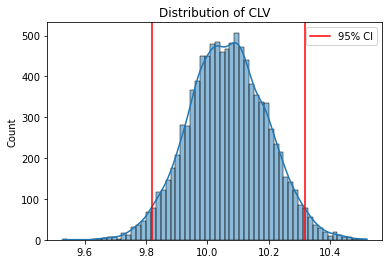

IC = [9.818621 , 10.318166 ] 


In [16]:
_,_ , clv_exp_cb = f.bootstrap_samples(Y_n, censored, f.exp_c_clv_estimator)
lower_exp_cb, upper_exp_cb  = f.CI_plot_95(clv_exp_cb, 0.05)

In [17]:
print("Bootstrapping method IC lower bound is %.3f %% different from the theoretical IC lower bound."%(round(100*abs(lower_exp_cb-lower_exp_ct)/lower_exp_cb,3)))
print("Bootstrapping method IC upper bound is %.3f %% different from the theoretical IC upper bound."%(round(100*abs(upper_exp_cb-upper_exp_ct)/upper_exp_cb,3)))

Bootstrapping method IC lower bound is 0.023 % different from the theoretical IC lower bound.
Bootstrapping method IC upper bound is 0.041 % different from the theoretical IC upper bound.


As we can see the bootstrapping method has less than 0.05% of error comparing to the theoretical bounds. So we can clearly conclude that when we cannot find and compute the formula of the confidence interval (which is commonly the case in practice since we don't know exactly the distribution of the data), the bootstrapping method can be a good solution.